In [75]:
import requests
import random
import pandas as pd
import os, pickle
import numpy as np
import networkx as nx
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("default")
plt.rcParams['figure.figsize'] = (15.25,8.75)
from math import sin, cos, radians, degrees, asin, atan2, sqrt
import shapely
from shapely.geometry import Point, LineString, Polygon
from copy import deepcopy as copy
from collections import Counter
from pprint import pprint as pp

## Modeling

In [9]:
def naive_distance(node1, node2, criteria=["name", "phone", "address", "hours", "url","location" ]):
    dist = 0
    for key in criteria:
        if node1.get(key) == node2.get(key) and node2.get(key) != None:
            dist+=1
    return 10/dist if dist != 0 else np.inf

def create_network(result,
                   weight_assignment=naive_distance,
                  cubic=False,
                  network_type=nx.Graph):
    network = nx.Graph() if not cubic else nx.cubical_graph()
    network.add_nodes_from([(i, result[i]) for i in range(len(result))])
    edges = []
    for node1 in network.nodes:
            for node2 in [_ for _ in network.nodes if _!=node1]:
                #if node1 != node2 and network.nodes[node1]["source"] != network.nodes[node2]["source"]:
                w = weight_assignment(network.nodes[node1], 
                                      network.nodes[node2])
                #if w != np.inf:
                edges.append((node1, node2, w))
    network.add_weighted_edges_from(edges)
    return network


In [209]:
def fancy_plot(network, layout, spring_w = None):
    """layout types : Look at nx.layout.ATTRS"""
    pos = layout(network) if layout != nx.layout.spring_layout else layout(network, weight=spring_w)
    plt.rcParams['figure.figsize'] = (15.25,7.75)
    #nodes
    nodetypes = dict(
    osm_nodes = [i for i in network.nodes if network.nodes[i]["source"] == "OSM"],
    fb_nodes = [i for i in network.nodes if network.nodes[i]["source"] == "facebook"],
    fs_nodes = [i for i in network.nodes if network.nodes[i]["source"] == "foursquare"],
    here_nodes = [i for i in network.nodes if network.nodes[i]["source"] == "here"],
    yelp_nodes = [i for i in network.nodes if network.nodes[i]["source"] == "yelp"])
    colors = dict(osm_nodes="black", fb_nodes="blue", fs_nodes="purple", here_nodes="r", yelp_nodes="yellow")
    for nodetype in nodetypes:  
        nx.draw_networkx_nodes(network,pos,
                               nodelist=nodetypes[nodetype],
                               node_color=colors[nodetype],
                               node_size=200,
                           alpha=.95, linewidths=2)

    # edges
    #if show_inf_dist:
    #    nx.draw_networkx_edges(network,pos,width=0.2,alpha=0.92, style="dashed")
    for (u, v, w) in network.edges(data=True):
        distance = w["weight"]["mean"]
        if distance == np.inf :
            continue
        width = 3/distance if distance != 0 else 3
        edge = (u, v)
        nx.draw_networkx_edges(network,pos,
                               edgelist=[edge],
                               width=width,alpha=1,edge_color="black")
    
    nx.draw_networkx_labels(network,pos,font_size=16, font_color="green")
    
    
    #nx.draw_networkx_edge_labels(network, pos,font_size=8, font_color="green", edge_labels=None)
    plt.axis("off")

## Creating a consistent distance across node attributes using LD

In [15]:
def LD(s,t, decapitalize=True):
    if decapitalize:
        s, t = s.lower(), t.lower()
    s = ' ' + s
    t = ' ' + t
    d = {}
    S = len(s)
    T = len(t)
    for i in range(S):
        d[i, 0] = i
    for j in range (T):
        d[0, j] = j
    for j in range(1,T):
        for i in range(1,S):
            if s[i] == t[j]:
                d[i, j] = d[i-1, j-1]
            else:
                d[i, j] = min(d[i-1, j], d[i, j-1], d[i-1, j-1]) + 1
    return d[S-1, T-1]

## Network based methods

In [14]:
from networkx.algorithms.shortest_paths.weighted import dijkstra_path as SP
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length as SP_dist

In [13]:
def assign_SP(network, method="mean"):
    ##Assign weights
    for node1 in network.nodes:
        for node2 in network.nodes:
            if node1!=node2:
                network.edges[node1, node2][method] = network.edges[node1, node2]["weight"][method]
    ##Search SP
    for node1 in network.nodes:
        for node2 in network.nodes:
            if node1 != node2: 
                try:
                    sp = nx.dijkstra_path(G=network, source=node1, target=node2, weight=method)
                    dist = nx.dijkstra_path_length(G=network, source=node1, target=node2, weight=method)
                except:
                    sp, dist = None, None
                network.edges[node1, node2]["weight"]["SP"] = sp
                network.edges[node1, node2]["weight"]["SP_dist"] = dist
    return network             

In [12]:
def format_data(net):
    global networks
    network = copy(net)
    net_id = networks.index(net)
    edges = list(network.edges(data=True))
    array = []
    for edge in edges:
        data = edge[2]["weight"]
        data["node_1"] = edge[0]
        data["node_2"] = edge[1]
        data["net_id"] = net_id
        data["net_nodes"] = len(net.nodes)
        data["net_edges"] = len(net.edges)
        array.append(data)
    return array

In [11]:
def LD_distance(node1, node2, criteria=["name", "phone", "address", "url"]):
    common = { i : None for i in criteria if all([i in node1, i in node2, node2.get(i) != None, node1.get(i) !=None])}
    n=len(common)
    for key in common:
        common[key] = LD(node1[key], node2[key])
    common["total"] = sum(list(common.values()))
    common["n_common"] = n
    common["mean"] = common["total"]/n
    for key in criteria:
        if key not in common:
            common[key] = None
    return common
def create_network(result,
                  cubic=False,
                  network_type=nx.Graph):
    network = nx.Graph() if not cubic else nx.cubical_graph()
    network.add_nodes_from([(i, result[i]) for i in range(len(result))])
    edges = []
    for node1 in network.nodes:
            for node2 in [_ for _ in network.nodes if _!=node1]:
                #if node1 != node2 and network.nodes[node1]["source"] != network.nodes[node2]["source"]:
                w = LD_distance(network.nodes[node1], network.nodes[node2])
                #if w != np.inf:
                edges.append((node1, node2, w))
    network.add_weighted_edges_from(edges)
    return assign_SP(network)


### Analysis of Network edges (Global)

- $N$ is a set of networks.
- Any network $G \in N$ has $n_{G} \in [2,12]$ nodes
- Each node has a set of attributes $A = [a_1, a_2, \dots, a_n] \gets ["name"; "address"; "phone", "website"]$
- For each network $G \in N$, there is a set of edges $E_{G}$
- Any edge $e \in E$ describes the distribution of LD distances for the nodes it connects in regards to their attributes.


An edge has the following properties:

- $e \gets f(a) \ \forall \ a \ \in A$, where $f = LD $ (string distance)
- $e$ also entails $N_A = A_n(e)$ and $T_{e}=  \sum_{i=1}^{N_{A}} a_i$
- To consider that there are not equally common attributes for all nodes this could be used :

$$
\mu_{e}(LD) =  \frac{1}{N_{A}} \sum_{i=1}^{N_{A}} a_i = \frac{T_{e}}{N_{A}}
$$


## Creating the newtorks (n=500)

In [28]:
networks = [create_network(i) for i in results]

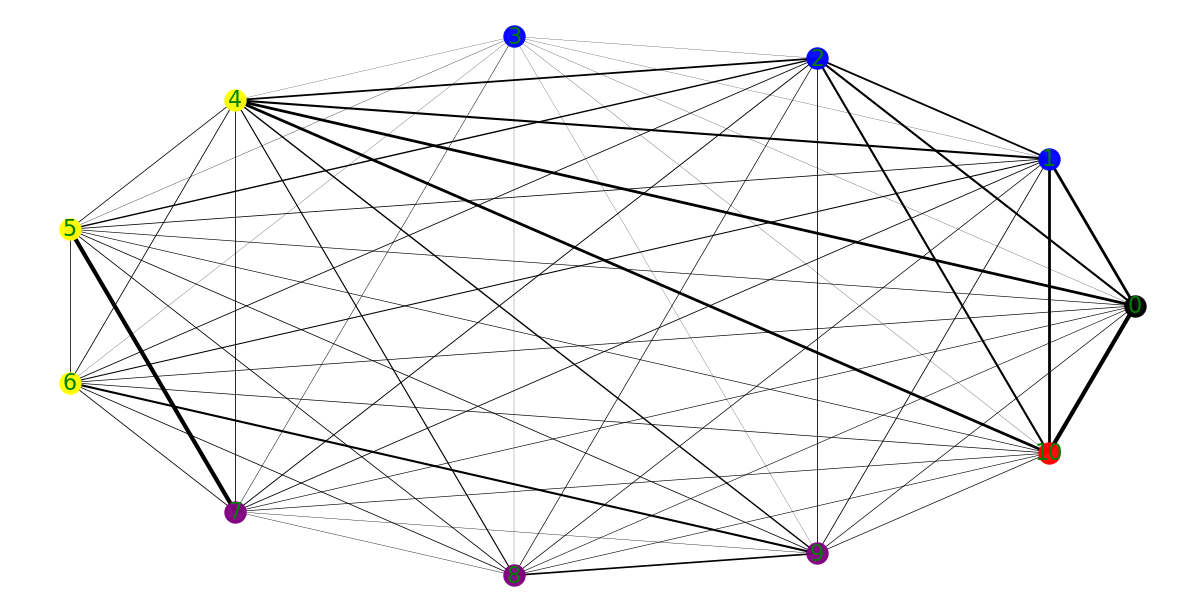

In [219]:
#visualized
fancy_plot(networks[144], layout=nx.layout.circular_layout);

In [235]:
plt.style.use("seaborn-pastel")

Text(0.5, 1.0, 'Number of Edges per Network')

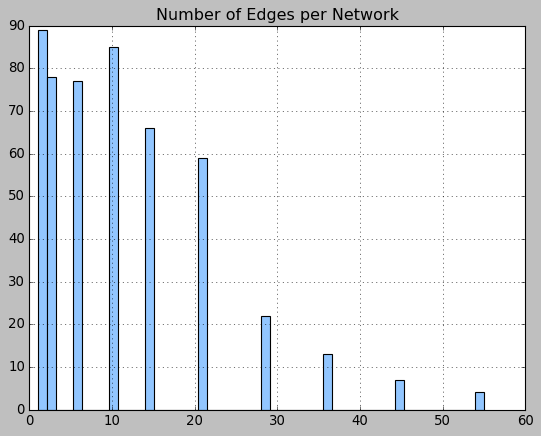

In [236]:
##Edge distribution for the acquired networks
pd.Series([len(network.edges) for network in networks]).hist(bins=50)
plt.title("Number of Edges per Network")

## Creating the Edge Pool


In [225]:
edges = []
for network in networks:
    edges += format_data(network)
df = pd.DataFrame(edges)
df["sum_dist"] = df["total"];del df["total"]
df["mean_dist"] = df["sum_dist"]/df["n_common"];del df["mean"]
##Create unique ID for each of the nodes
df["node_1_ID"] =  df["net_id"].astype("str")+"_"+df["node_1"].astype("str")
df["node_2_ID"] =  df["net_id"].astype("str")+"_"+df["node_2"].astype("str")

In [20]:
print("There are {} total networks and {} edges".format(len(networks), len(edges)))

There are 500 total networks and 5483 edges


In [21]:
df.columns

Index(['name', 'address', 'n_common', 'phone', 'url', 'SP', 'SP_dist',
       'node_1', 'node_2', 'net_id', 'net_nodes', 'net_edges', 'sum_dist',
       'mean_dist', 'node_1_ID', 'node_2_ID'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa1d618e90>,
      dtype=object)

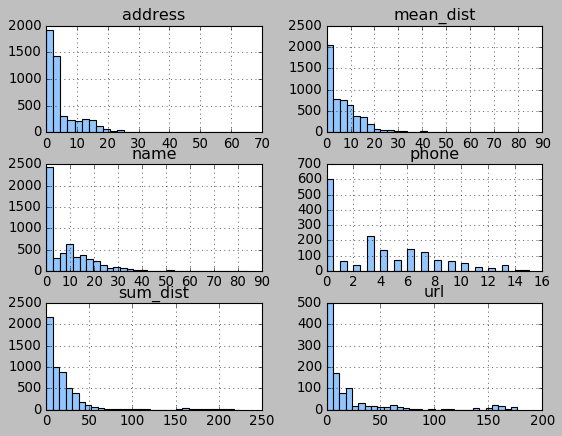

In [237]:
## Distribution of distance for all variables
df[['name', 'address', 'url', 'phone', "mean_dist", "sum_dist"]].hist(bins=30, align="mid")

In [23]:
df.head()

,name,address,n_common,phone,url,SP,SP_dist,node_1,node_2,net_id,net_nodes,net_edges,sum_dist,mean_dist,node_1_ID,node_2_ID
0,9,2.0,2,NaN,NaN,"[1, 0]",5.500000,0,1,0,2,1,11,5.500000,0_0,0_1
1,0,NaN,2,NaN,1.0,"[1, 4, 0]",0.000000,0,1,1,5,10,1,0.500000,1_0,1_1
2,0,3.0,3,NaN,155.0,"[2, 4, 0]",1.500000,0,2,1,5,10,158,52.666667,1_0,1_2
3,0,3.0,3,NaN,2.0,"[3, 1, 4, 0]",0.333333,0,3,1,5,10,5,1.666667,1_0,1_3
4,0,0.0,2,NaN,NaN,"[4, 0]",0.000000,0,4,1,5,10,0,0.000000,1_0,1_4


## 3.) Search for all Matches


In [24]:
def find_partners(data, net_id, target=0,
                 method="mean_dist",
                 T=0, closed_T = False):
    """Finds all direct and indirect matching partners given a node"""
    df = data.copy()
    #subset network
    df = df[df["net_id"] == net_id]
    #Find all matches 
    df = df[df[method] <= T] if not closed_T else df[df[method] < T]
    #Find all direct OSM matches
    matches = df[(df["node_1"] == target) | (df["node_2"] == target)]
    #print("Iteration 0 : {} direct partners ".format(len(matches)))
    #Save the match partners
    partners = set(matches["node_2_ID"].to_list() + matches["node_1_ID"].to_list())
    partners = set([i for i in partners if i != target])
    # Search for additional matches
    df_no_target = df[(df["node_1"] != target) & (df["node_2"] != target)]
    old_count = len(partners)
    new_count = 99999
    iteration = 1
    while new_count > old_count:
        old_count = len(partners)
        add_matches = df_no_target[(df_no_target["node_1_ID"].isin(partners)) | (df_no_target["node_2_ID"].isin(partners))]
        for _ in zip(add_matches["node_1_ID"], add_matches["node_2_ID"]):
            partners.add(_[0])
            partners.add(_[1])
        new_count = len(partners)
        #print("Iteration {} : {} additional partners ".format(iteration, new_count - old_count))
        iteration += 1
    #print("Total direct matches : {}".format(len(osm_matches)))
    #print("Additional indirect matches : {}".format(len(partners) - len(osm_matches)))
    return partners

def find_matches(df, net_id, method="mean_dist", T=0):
    """Finds all direct and indirect matches within a network given a method and a threshold"""
    def is_in(pair, array):
        """double checks for duplicates (slow but safe)"""
        a, b = pair
        if pair in array:
            return True
        else:
            for match in array:
                if a in match and b in match:
                    return True
            return False
    #set of all nodes that fit the criteria 
    nodes = set(df["node_1"].to_list() + df["node_2"].to_list())
    matches = list()
    for node in nodes:
        p = find_partners(df, net_id, target=node, method=method, T=T)
        l = list()
        for a in p:
            for b in p:
                if a!=b:
                    l.append((a, b))
        for i in l:
            if not is_in(i, matches):
                matches.append(i)
    return matches


## Estimating the gains in total matches due to indirect match inference


In [25]:
method = "mean_dist"
T = 2
#This may take some time
matches = pd.DataFrame({"net_id": list(range(len(networks))) ,
                        "direct_matches" : [len(df[(df["net_id"] == i)&(df[method] <= T)]) for i in list(range(len(networks)))],
                        "total_matches" : [len(find_matches(df,i, method=method, T=T)) for i in list(range(len(networks)))]})
matches = matches[matches["direct_matches"] != 0]
matches["gain"] = matches["total_matches"] - matches["direct_matches"]

In [238]:
matches.head()

,net_id,direct_matches,total_matches,gain
1,1,7,10,3
2,2,6,6,0
3,3,1,1,0
4,4,5,10,5
5,5,6,15,9


array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa1d678790>,
      dtype=object)

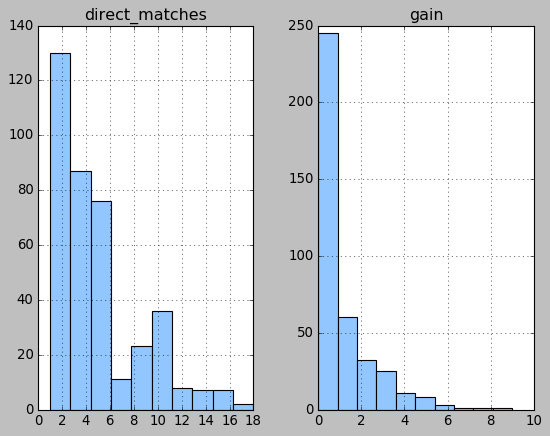

In [239]:
matches[["direct_matches", "gain"]].hist(align="mid")

### Total direct matches globally

In [740]:
matches["direct_matches"].mean()

4.777777777777778

In [741]:
matches["direct_matches"].sum()

1849

### Total Gain in matches globally

In [742]:
matches["gain"].mean()

0.8397932816537468

In [743]:
matches["gain"].sum()

325

## Pair-wise distributions of the the data sources

In [240]:
#Create Source columns
df['source_1'] = df.apply(lambda row : networks[row["net_id"]].nodes[row["node_1"]]["source"], axis=1)
df['source_2'] = df.apply(lambda row : networks[row["net_id"]].nodes[row["node_2"]]["source"], axis=1)
#Create pair identifier column
df['pair'] = df.apply(lambda row : row["source_1"] +"+"+ row["source_2"], axis=1)

In [241]:
df.head()

,name,address,n_common,phone,url,SP,SP_dist,node_1,node_2,net_id,net_nodes,net_edges,sum_dist,mean_dist,node_1_ID,node_2_ID,source_1,source_2,pair
0,9,2.0,2,NaN,NaN,"[1, 0]",5.500000,0,1,0,2,1,11,5.500000,0_0,0_1,OSM,here,OSM+here
1,0,NaN,2,NaN,1.0,"[1, 4, 0]",0.000000,0,1,1,5,10,1,0.500000,1_0,1_1,OSM,facebook,OSM+facebook
2,0,3.0,3,NaN,155.0,"[2, 4, 0]",1.500000,0,2,1,5,10,158,52.666667,1_0,1_2,OSM,yelp,OSM+yelp
3,0,3.0,3,NaN,2.0,"[3, 1, 4, 0]",0.333333,0,3,1,5,10,5,1.666667,1_0,1_3,OSM,foursquare,OSM+foursquare
4,0,0.0,2,NaN,NaN,"[4, 0]",0.000000,0,4,1,5,10,0,0.000000,1_0,1_4,OSM,here,OSM+here


Text(0.5, 1.0, 'Distribution of Pairs (Not Matches)')

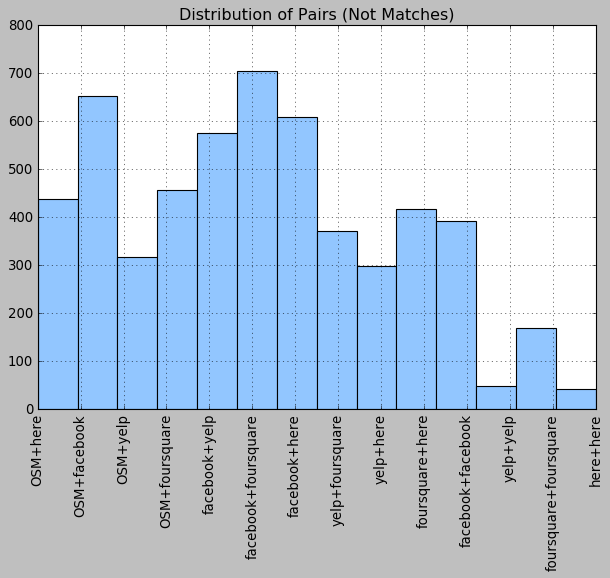

In [242]:
df['pair'].hist(bins= len(df['pair'].unique()), figsize=(9, 6), align="mid");plt.xticks(rotation='vertical')
plt.title("Distribution of Pairs (Not Matches)")

## Pair-wise distributions of the objective variables (LD distances)

### Mean LD  per Pair

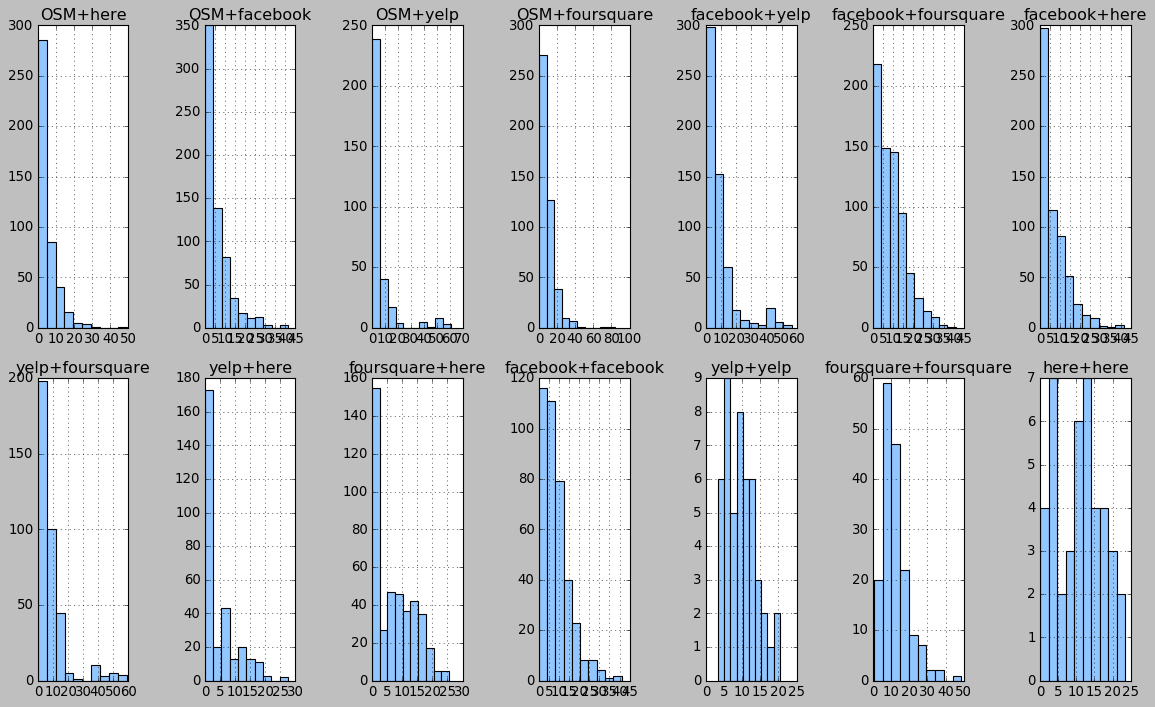

In [243]:
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(14.5,9))
r, c = 0, 0
for pair in df["pair"].unique():
    df[df["pair"] == pair]["mean_dist"].hist(ax=axes[r, c])
    axes[r, c].set_title(pair)
    c += 1
    if c == 7:
        r, c= 1, 0

fig.tight_layout()


In [567]:
method = "mean_dist"
T = 0
for pair in df["pair"].unique():
    print(pair,"direct matches <--- ", len(df[(df["pair"] == pair)&(df[method] == T)]))

OSM+here direct matches <---  176
OSM+facebook direct matches <---  95
OSM+yelp direct matches <---  20
OSM+foursquare direct matches <---  24
facebook+yelp direct matches <---  39
facebook+foursquare direct matches <---  33
facebook+here direct matches <---  97
yelp+foursquare direct matches <---  71
yelp+here direct matches <---  24
foursquare+here direct matches <---  35
facebook+facebook direct matches <---  30
yelp+yelp direct matches <---  0
foursquare+foursquare direct matches <---  0
here+here direct matches <---  2


## Testing Otsu's Method for numerical data


In [570]:
def within_class_variance(data, T):
    #Create a properly indexed (but slow) histogram
    n = len(data)
    hist = list()
    for i in data.unique():
        hist.append(data.value_counts().loc[i])   
    #class hists
    hist_0 = [count for count in hist if hist.index(count) < T]
    hist_1 = [count for count in hist if hist.index(count) >= T]
    #vals_0 = [hist.index(i) for i in hist_0]
    #vals_1 = [hist.index(i) for i in hist_1]
    n_0, n_1 = sum(hist_0), sum(hist_1)

    #class weights
    weight_0 = sum(hist_0) / n
    weight_1 = sum(hist_1) / n
    #class mean occurence
    mean_count_0 = sum([count * hist.index(count) for count in hist_0]) / n_0 if n_0 != 0 else 0
    mean_count_1 = sum([count * hist.index(count) for count in hist_1]) / n_1 if n_1 != 0 else 0
    #weighted var per class
    var_0 = sum([((hist.index(count) - mean_count_0)**2 ) * count for count in hist_0]) / n_0 if n_0 != 0 else 0
    var_1 = sum([((hist.index(count) - mean_count_1)**2 ) * count for count in hist_1]) / n_1 if n_1 != 0 else 0

    return weight_0 * var_0 + weight_1 * var_1

def find_T(data):
    thresholds = list(data.unique())
    res = [ within_class_variance(data, T) for T in thresholds ]
    return thresholds[res.index(min(res))]

In [569]:
def visualize(data):
    if type(data) != pd.Series:
        raise ValueError
    T = find_T(data.dropna())
    ax = data.hist(bins=65)
    plt.title("Threshold which minimizes within class variance : T = {}".format(T))
    ax.axvline(x=T, color='r', linestyle='dashed', linewidth=1)

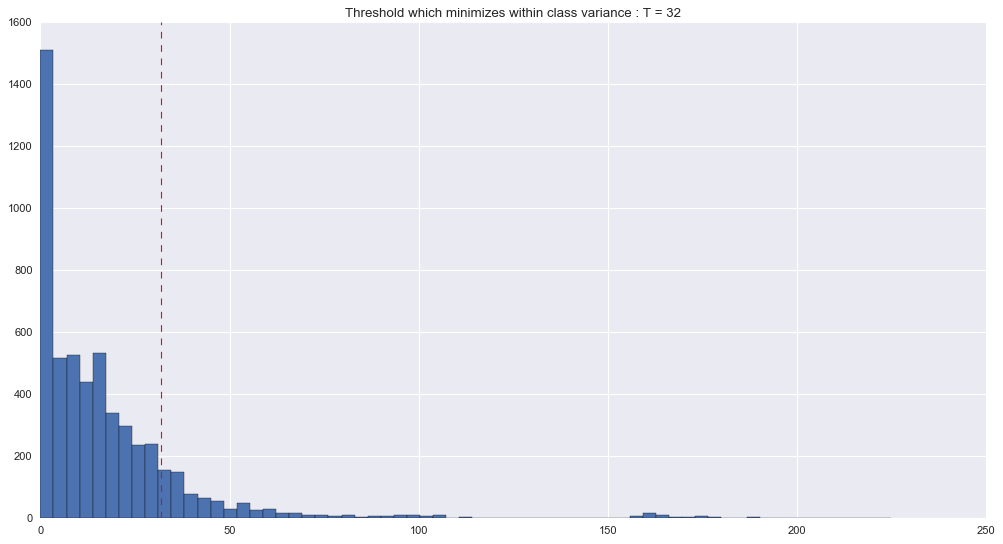

In [744]:
visualize(df["sum_dist"])

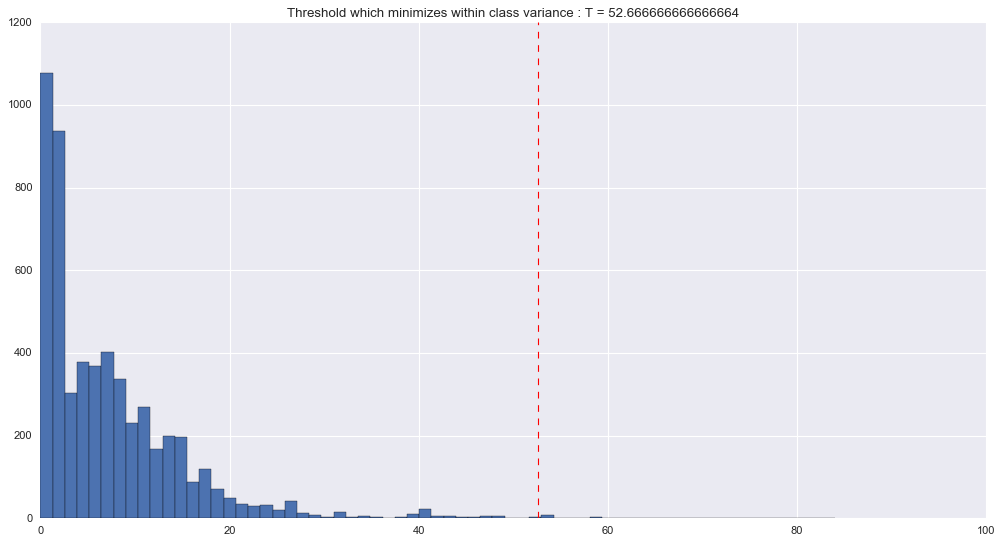

In [745]:
visualize(df["mean_dist"])

## Matches According to the "Within Class Variance Minimizer"

In [573]:
T = 32

#### For Mean distance T=33

In [574]:
pd.Series([ 1 if mean_distance < T else 0 for mean_distance in df["mean_dist"]]).value_counts()

1    5371
0     112
dtype: int64

#### For Mean distance == 0

In [575]:
pd.Series([ 1 if mean_distance == 0 else 0 for mean_distance in df["sum_dist"]]).value_counts()

0    4837
1     646
dtype: int64

#### For Mean distance in 15% Quantile

In [576]:
Q15 = df["mean_dist"].quantile(.15)
pd.Series([ 1 if mean_distance <= Q15 else 0 for mean_distance in df["mean_dist"]]).value_counts()

0    4659
1     824
dtype: int64

## "Best-Best" Method (Node-Based)
- If two nodes have the smallest distance to each other those two nodes become a match
- By doing that the tradeoff between true matches and total matches will not be optimized.
- Also, this method can be biased by the fact that node 0 (OSM) is used to initialize all other nodes, which will give the best match mostly with 0 and could be equivalent to searching the best match for 0


In [577]:
def best_best(net, target="mean"):
    network = copy(net)
    nodes = dict()
    for node1 in network.nodes:
        candidates = dict()
        for node2 in network.nodes:
            if node1 != node2:
                candidates[node2] = LD_distance(network.nodes[node1], network.nodes[node2])[target]
        nodes[node1] = candidates
    matches = []
    found = []
    for node1 in nodes:
        for node2 in nodes:
            if node1 != node2 and all([node1 not in found, node2 not in found]):
                if nodes[node1][node2] == min(nodes[node1].values()) and nodes[node2][node1] == min(nodes[node2].values()):
                    found += [node1, node2]
                    matches.append((node1, node2))
    return matches             

In [578]:
matches_mean = []
matches_sum = []
for network in networks:
    matches_mean += best_best(network, target="mean")
    matches_sum += best_best(network, target="total")
print("Matches according to Best_Best (target=mean) <- ", len(matches_mean))
print("Matches according to Best_Best (target=total) <- ", len(matches_sum))

Matches according to Best_Best (target=mean) <-  716
Matches according to Best_Best (target=total) <-  717
